Uvoz knjižnic in branje podatkov iz datotek:

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

In [2]:
list_of_cvs = ["./podatki/kd{}.csv".format(i) for i in range(2010,2020)]
frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
df = pd.concat(frames)

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_10268\1644075804.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_10268\1644075804.py:2: DtypeWarning: Columns (14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]


In [3]:
#group by mesec, count unique id
kd_leto = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
leto_counter = defaultdict(int)

for name,v in kd_leto:
    index = int((name[0].split(".")[1]))
    if index >= 2010 and index < 2020:
        leto_counter[index] +=1
    


list_mes_counter = sorted(leto_counter.items())
mesec, counter = zip(*list_mes_counter)
""" plt.figure(figsize=(15,10))
plt.plot(mesec,counter)
plt.show() """

' plt.figure(figsize=(15,10))\nplt.plot(mesec,counter)\nplt.show() '

In [4]:
pijaniMladoletniki = df.groupby(['StarostniRazred', 'Skoda'])
skodaStarostStevilo = defaultdict(lambda: defaultdict(int))
for name, v in pijaniMladoletniki:
    skodaStarostStevilo[name[1]][name[0]] = len(v['ZaporednaStevilkaKD'].unique())

skodaStarostStevilo

defaultdict(<function __main__.<lambda>()>,
            {'1.000 - 10.000 EUR': defaultdict(int,
                         {'00-07': 130,
                          '07-14': 245,
                          '14-16': 172,
                          '16-18': 327,
                          '18-24': 2718,
                          '24-34': 11476,
                          '34-44': 15831,
                          '44-54': 15437,
                          '54-64': 11420,
                          'NAD 64': 8733,
                          'NI PODATKA': 45,
                          'NI POJAVA': 7,
                          'PRAVNA OSEBA': 34901}),
             '10.000 - 100.000 EUR': defaultdict(int,
                         {'00-07': 4,
                          '07-14': 26,
                          '14-16': 17,
                          '16-18': 18,
                          '18-24': 247,
                          '24-34': 1688,
                          '34-44': 2729,
                         

In [5]:
def wihtout_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

In [6]:
## Največji kršitelji po rangu vrednosti v procentih. BREZ PRAVNIH OSEB
import operator
invalid = {"PRAVNA OSEBA"}
for k, v in skodaStarostStevilo.items():
    v = wihtout_keys(v, invalid)
    print("Vrednost: %s \n Starost: %s\n Delež:%.2f %%" % (k, max(v.items(), key=operator.itemgetter(1)), max(v.values())/sum(v.values())*100))

Vrednost: 1.000 - 10.000 EUR 
 Starost: ('34-44', 15831)
 Delež:23.79 %
Vrednost: 10.000 - 100.000 EUR 
 Starost: ('44-54', 2756)
 Delež:24.77 %
Vrednost: 100 - 1.000 EUR 
 Starost: ('34-44', 37573)
 Delež:19.84 %
Vrednost: 100.000 - 500.000 EUR 
 Starost: ('44-54', 245)
 Delež:26.98 %
Vrednost: BREZ 
 Starost: ('34-44', 77155)
 Delež:20.64 %
Vrednost: DO 100 EUR 
 Starost: ('34-44', 18599)
 Delež:19.85 %
Vrednost: NAD 500.000 EUR 
 Starost: ('44-54', 41)
 Delež:28.47 %


In [7]:
#Dictionary ENOTA{kaznivo dejanje: stevilo teh dejanj}
#idea Porazdelitev vrst kaznivih dejanj po posamezni enoti/občini/karkol se jim reče

#ZaporednaStevilkaKD;MesecStoritve;UraStoritve;OpisKD

kd_leto = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD', 'OpisKD', 'PUStoritveKD'])

kraj_dejanje = defaultdict(lambda: defaultdict(int))
for k, v in kd_leto:
    #print(k, len(v))
    kraj_dejanje[k[-1]][k[-2].split(" - ")[1]] += len(v)

('01.1944', '00:00-00:59', 15723, 'KZ08/101-/1// - HUDODELSTVA ZOPER ÈLOVEÈNOST', 'PU KRANJ') 1
('01.1978', '00:00-00:59', 75804, 'KZ08/173-/1// - SPOLNI NAPAD NA OSEBO,  MLAJŠO OD PETNAJST LET', 'PU KRANJ') 2
('01.1979', '00:00-00:59', 45042, 'KZ12/118*/1// - POVZROÈITEV SMRTI IZ MALOMARNOSTI', 'PU MURSKA SOBOTA') 2
('01.1981', '00:00-00:59', 42610, 'KZ08/173-/3// - SPOLNI NAPAD NA OSEBO,  MLAJŠO OD PETNAJST LET', 'PU NOVO MESTO') 1
('01.1982', '00:00-00:59', 22407, 'KZ08/211-/1/S/ - GOLJUFIJA', 'PU LJUBLJANA') 2
('01.1982', '00:00-00:59', 24932, 'KD02/103/1// - SPOLNI NAPAD NA OSEBO MLAJŠO OD 14 LET', 'PU LJUBLJANA') 2
('01.1983', '10:00-10:59', 3308, 'KD02/103/1// - SPOLNI NAPAD NA OSEBO MLAJŠO OD 14 LET', 'PU KOPER') 2
('01.1984', '12:00-12:59', 9552, 'KZ12/173*/3// - SPOLNI NAPAD NA OSEBO,  MLAJŠO OD PETNAJST LET', 'PU NOVO MESTO') 2
('01.1984', '23:00-23:59', 40075, 'KZ08/173-/1// - SPOLNI NAPAD NA OSEBO,  MLAJŠO OD PETNAJST LET', 'PU KOPER') 2

In [8]:
df["TIP-DEJANJA"] = df.apply(lambda row: row["OpisKD"].split(" - ")[1], axis=1)
kd = df.groupby(["TIP-DEJANJA"])


##TOP 10 KAZNIVIH DEJANJ, ki jih bomo izrisali na grafu
top10 = sorted([(k, len(v)) for k, v in kd], key = lambda x: x[1], reverse=True)[:10]
top10Dejanja = [x[0] for x in top10]

In [9]:
top10Dejanja

['TATVINA',
 'VELIKA TATVINA',
 'GOLJUFIJA',
 'KRŠITEV TEMELJNIH PRAVIC DELAVCEV',
 'POSLOVNA GOLJUFIJA',
 'POŠKODOVANJE TUJE STVARI',
 'NEPLAÈEVANJE PREŽIVNINE',
 'NASILJE V DRUŽINI',
 'GROŽNJA',
 'LAHKA TELESNA POŠKODBA']

In [10]:
vse = 0
KD_procenti = defaultdict(list)

for kraj, slovar in kraj_dejanje.items():
    if kraj in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]: continue
    tmp = sorted([(k, v) for k, v in slovar.items()], key=lambda x: x[0])[::-1] # LIST OF TUPLES => (TATVINA : 23025)
    stevilo = sum([x[1] for x in tmp])
    print("%s:  %d" % (kraj, stevilo))
    procenti = 0
    ostalo = 0
    for x in tmp:
        if x[0] in top10Dejanja:
            procenti += x[1]/stevilo*100
            KD_procenti[x[0]].append(x[1]/stevilo*100)
            print("\t%s : %d  %f%%" % (x[0], x[1], x[1]/stevilo*100))
            vse += x[1]
            ostalo += x[1]
    KD_procenti["OSTALO"].append(100 - procenti)
    print("\tOSTALO: %d  %f%%" % (stevilo - ostalo, 100 - procenti))
    print("\n")

PU KRANJ:  95341
	VELIKA TATVINA : 11434  11.992742%
	TATVINA : 23025  24.150156%
	POŠKODOVANJE TUJE STVARI : 4653  4.880377%
	POSLOVNA GOLJUFIJA : 5371  5.633463%
	NEPLAÈEVANJE PREŽIVNINE : 6576  6.897347%
	NASILJE V DRUŽINI : 1719  1.803002%
	LAHKA TELESNA POŠKODBA : 2758  2.892774%
	KRŠITEV TEMELJNIH PRAVIC DELAVCEV : 2307  2.419735%
	GROŽNJA : 2774  2.909556%
	GOLJUFIJA : 6483  6.799803%
	OSTALO: 28241  29.621044%


PU MURSKA SOBOTA:  65207
	VELIKA TATVINA : 4840  7.422516%
	TATVINA : 10474  16.062693%
	POŠKODOVANJE TUJE STVARI : 2568  3.938227%
	POSLOVNA GOLJUFIJA : 2148  3.294125%
	NEPLAÈEVANJE PREŽIVNINE : 2412  3.698989%
	NASILJE V DRUŽINI : 2752  4.220406%
	LAHKA TELESNA POŠKODBA : 2137  3.277256%
	KRŠITEV TEMELJNIH PRAVIC DELAVCEV : 12867  19.732544%
	GROŽNJA : 2222  3.407610%
	GOLJUFIJA : 4795  7.353505%
	OSTALO: 17992  27.592130%


PU NOVO MESTO:  109241
	VELIKA TATVINA : 13005  11.904871%
	TATVINA : 24797  22.699353%
	POŠKODOVANJE TUJE STVARI : 4360  3.991175%
	POSLOVNA GO

In [11]:
#https://stackoverflow.com/a/50205834
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [12]:
colorss = [
'white',
'black',
'grey',
'yellow',
'red',
'blue',
'green',
'brown',
'oink',
'orange',
'purple']

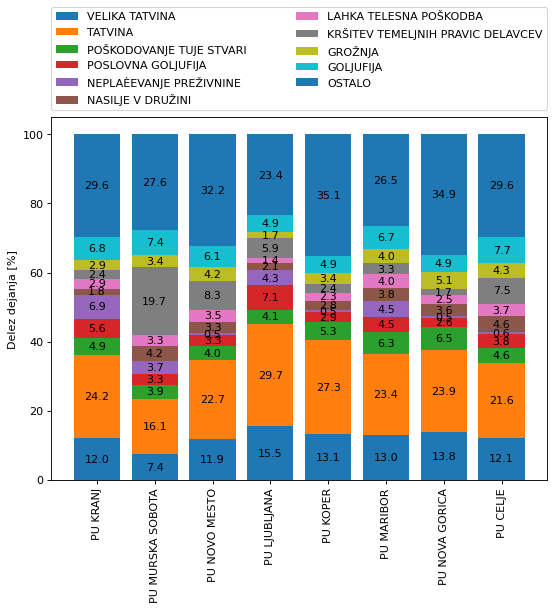

' fig, ax = plt.subplots()\n\nax.set_ylabel("Delez dejanja")\nax.set_title("Delez kaznivih dejanj po PU")\nax.legend()\nplt.show() '

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
header = ['VELIKA TATVINA', 'TATVINA', 'POŠKODOVANJE TUJE STVARI', 'POSLOVNA GOLJUFIJA', 'NEPLAÈEVANJE PREŽIVNINE', 'NASILJE V DRUŽINI', 'LAHKA TELESNA POŠKODBA', 'KRŠITEV TEMELJNIH PRAVIC DELAVCEV', 'GROŽNJA', 'GOLJUFIJA', 'OSTALO']
labels = [kraj for kraj, slovar in kraj_dejanje.items() if kraj not in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]]
dataset = [v for k,v in KD_procenti.items()]

plt.figure(figsize=(8, 6), dpi=80)
plot_stacked_bar(
    dataset,
    header,
    category_labels=labels,
    show_values=True,
    value_format="{:.1f}",
    y_label= "Delez dejanja [%]",
)

l4 = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.xticks(rotation=90)
plt.show()


""" fig, ax = plt.subplots()

ax.set_ylabel("Delez dejanja")
ax.set_title("Delez kaznivih dejanj po PU")
ax.legend()
plt.show() """


In [14]:
print(labels)

['PU KRANJ', 'PU MURSKA SOBOTA', 'PU NOVO MESTO', 'PU LJUBLJANA', 'PU KOPER', 'PU MARIBOR', 'PU NOVA GORICA', 'PU CELJE']
